# Load stuff

In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')
from scipy.sparse import csr_matrix
import scipy.sparse as sps
import matplotlib.pyplot as plt
!pip install leidenalg # this is the Louvain version we use!!!!
import leidenalg
import igraph as ig
import pickle
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.cm
!pip install umap-learn
import umap
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00


In [2]:
!pip install bertopic
from bertopic import BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.2 MB/s eta 0:00:00


In [3]:
class CleanText:
    # in the default mode we leave aside "PRON", they appear too many times
    def __init__(self, text, POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB"]):
        # capture execution time
        tic = time.time()
        # store original text
        self.text = list(text)
        # superficially clean it
        sup_clean = [self._superficial_cleaning(i) for i in self.text]
        # store deep cleaning of text
        self.text_clean = [self._deep_cleaning(i,POS_KEEP) for i in sup_clean]
        # store deep cleaning of POS
        self.pos_clean = [self._deep_cleaning_pos(i,POS_KEEP) for i in sup_clean]
        # capture execution time
        print(f'Cleaning text: execution time {time.time()-tic} [s]')

    def _superficial_cleaning(self, selftext):
        # Remove any HTML tag
        soup = BeautifulSoup(selftext, "html.parser")
        outtext = soup.get_text(separator=" ")
        # Remove any text inside square brackets
        outtext = re.sub(r'\[.*?\]', '', outtext)
        # Remove any website links
        outtext = re.sub(r'http\S+', '', outtext)
        outtext = re.sub(r'www.\S+', '', outtext)
        outtext = outtext.replace('. com', '.com')
        # Remove '&amp;#x200B;\n\'
        outtext = re.sub(r'&amp;#x200B;\n\\', ' ', outtext)
        outtext = re.sub(r'‚Äú', ' ', outtext)
        outtext = re.sub(r'‚Äô', "’", outtext)
        # Remove double spaces, newlines, tabs, and combinations
        outtext = re.sub(r' +', ' ', outtext)
        outtext = re.sub(r'\s{2,}', ' ', outtext)
        outtext = re.sub(r'&gt;', ' ', outtext)
        outtext = outtext.replace('-', ' ')
        outtext = outtext.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
        # Reduce repetition to two characters for alphabets and to
        # one character for punctuations
        Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
        Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
        outtext = Pattern_alpha.sub(r"\1\1", outtext)
        outtext = Pattern_Punct.sub(r'\1', outtext)
        outtext = re.sub(' {2,}',' ', outtext)
        # Remove extra whitespaces from the text
        pattern = re.compile(r'\s+')
        Without_whitespace = re.sub(pattern, ' ', outtext)
        outtext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        return outtext

    def _deep_cleaning(self, selftext,POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = ' '.join([token.lemma_ for token in nlp(selftext) if token.pos_ in POS_KEEP])
        return outtext

    def _deep_cleaning_pos(self, selftext,POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = [' '.join([token.lemma_,token.pos_]) for token in nlp(selftext) if token.pos_ in POS_KEEP]
        return outtext

In [4]:
def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y

def nmi_fn(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

def modularity_fn(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def ncut_fn(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def pagerank_fn(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

def _infomap_fn(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank_fn(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = pagerank_fn(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T
    return r

def infomap_fn(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = (C.T).dot(sps.diags(r.toarray().flatten()))
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = ((C[:,i].transpose()).dot(M)).dot(z[i].transpose())
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = _infomap_fn(q)
    for i in range(z.shape[0]):
      y += _infomap_fn(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/_infomap_fn(pd))-1
    return y

def _hlstr(string: str , color: str = 'white'):
    # return f"<mark style=background-color:{color}>{string} </mark>"
    return f"<span style=\"color:{color}\">{string} </span>"

def _colorize(attrs: np.ndarray, cmap: str = 'PiYG'):
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.colormaps.get_cmap(cmap)
    return list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))

def _display_html(tokens, attrs, co=1):
    return HTML("".join(list(map(_hlstr, tokens, _colorize(co*attrs)))))

def get_words_html(vec,wor,N):
    ind = np.argsort(-vec)
    wor = wor[ind[:N]]
    vec = vec[ind[:N]]
    vec = vec/vec[0]
    for j in range(len(wor)):
        wor[j] = str(nlp(str(wor[j]))[0].lemma_)
    return _display_html(wor,vec).data

In [5]:
class TopicDetection:
    # builds an occurrence matrix for words
    def __init__(self, ct_class=[], n_min=2, n_max=1e10):
      if ct_class:
        # capture execution time
        tic = time.time()
        # collection of words
        self.words = np.unique([item for sublist in ct_class.pos_clean for item in sublist])
        # words dictionary
        words_dict = dict(zip(self.words,range(len(self.words))))
        # occurrence matrix for words
        self.Mwd = csr_matrix((len(self.words), len(ct_class.text)), dtype = np.int8).toarray()
        for i in range(len(ct_class.text)):
            for j in ct_class.pos_clean[i]:
                self.Mwd[words_dict[j],i] += 1
        # documents list
        self.documents = np.array(range(len(ct_class.text)))
        # remove words that are used once or twice
        select = ((np.sum(self.Mwd,axis=1)>=n_min)&(np.sum(self.Mwd,axis=1)<n_max))
        print('removing words...')
        with np.printoptions(threshold=np.inf):
          print(self.words[(np.sum(self.Mwd,axis=1)>=n_max)])
        self.Mwd = self.Mwd[select,:]
        self.words = self.words[select]
        # remove documents that do not contain words
        select = (np.sum(self.Mwd,axis=0)>0)
        self.Mwd = csr_matrix(self.Mwd[:,select])
        self.documents = self.documents[select]
        # capture execution time
        print(f'Occurrence matrix: execution time {time.time()-tic} [s]')

    # plots words occurrencies
    def plot_word_occurrence(self):
        plt.figure(figsize=(4, 3))
        plt.semilogy(-np.sort(-np.asarray(np.sum(td1.Mwd,axis=1)).reshape(-1)))
        plt.grid(True)
        plt.xlabel('word id')
        plt.ylabel('# of occurrences')
        plt.title("words occurrencies")

    # plots degree distributions
    def plot_degree_distributions(self,quale='words'):
        if quale=='words':
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=1))) # words degrees
        else:
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=0))) # documents degrees
        # degree distribution
        k = np.unique(dw)
        pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
        pk = pk/pk.sum()
        Pk = 1-np.cumsum(pk)
        # plot
        fig = plt.figure(figsize=(4, 3))
        plt.loglog(k,pk,'o')
        if quale=='words':
            plt.title("degree distribution for words")
        else:
            plt.title("degree distribution for documents")
        plt.xlabel("k")
        plt.ylabel("pk")
        plt.grid(True)
        plt.show()

    # build probability matrices
    def probability_matrices(self, equalik = True, tform = False):
        # capture execution time
        tic = time.time()
        if equalik: # documents equally likely
            self.Pwd = self.Mwd/self.Mwd.sum(axis=0).flatten()/self.Mwd.shape[1]
        else: # documents proportional to their length
            self.Pwd = self.Mwd/self.Mwd.sum()
        # TF-IDF format
        if (tform):
            iw = -logg(np.sum(self.Mwd>0,axis=1).flatten()/self.Mwd.shape[1])
            self.Pwd = sps.diags(np.array(iw)[0]).dot(self.Pwd) # TF-IDF form
            self.Pwd = self.Pwd/self.Pwd.sum() # normalize, treat it as Pwd
        # words and document matrices
        self.pd = self.Pwd.sum(axis=0).flatten()
        self.Pww = (self.Pwd/self.pd).dot(self.Pwd.T)
        self.pw = self.Pwd.sum(axis=1).flatten()
        self.Pdd = (self.Pwd.T/self.pw).dot(self.Pwd)
        # # joint words and document matrix - documents first
        # self.Paa = sps.hstack((sps.csr_matrix((self.Pwd.shape[1],self.Pwd.shape[1])),self.Pwd.T))
        # self.Paa = sps.vstack((self.Paa,sps.hstack((self.Pwd,sps.csr_matrix((self.Pwd.shape[0],self.Pwd.shape[0]))))))
        # self.Paa = self.Paa/2.0
        # ranking vector for Infomap
        self.rd = infomap_rank_fn(self.Pdd)
        # capture execution time
        print(f'Probability matrices: execution time {time.time()-tic} [s]')

    # run topic detection using Louvain
    def topic_detection_louvain(self):
        # capture execution time
        tic = time.time()

        # build a graph based on Pdd as adjacency matrix
        A = sps.csr_matrix(self.Pdd)
        G = ig.Graph.Adjacency((A > 0).toarray().tolist())
        G.es['weight'] = np.array(A[A.nonzero()])[0]
        # run Louvain on the graph to get a partition
        self.topics = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition,
                                        weights='weight')
        # map the partition into a community assignment matrix C
        self.C = self._partition_to_C()
        self.topics = [np.argmax(i) for i in self.C] # turn C into a vector!
        # updates topic matrices
        self.Pwc = self.Pwd.dot(self.C) # joint word + class probability
        self.Pcc = ((self.C.T).dot(self.Pdd)).dot(self.C) # joint class + class probability
        self.pc = self.Pcc.sum(axis=0)

        # capture execution time
        ext = time.time()-tic
        print(f'Louvain topic detection: execution time {ext} [s]')
        return ext

    # function to map the partition into a community assignment matrix C
    # where rows represent documents, and columns represent topics
    def _partition_to_C(self):
      C = sps.csr_matrix((self.Pdd.shape[0],len(self.topics)))
      for i in range(len(self.topics)):
        C[np.array(self.topics[i]),i] = 1
      return C

    # display clustering metrics
    def clustering_metrics(self, ext=np.inf):
        NMI = nmi_fn(self.Pwc)
        Q = modularity_fn(self.Pcc)
        Ncut = ncut_fn(self.Pcc)
        Infomap = infomap_fn(self.C,self.Pdd,self.rd)
        if (self.pc.shape[1]==1):
            com = 0
        else:
            com = _infomap_fn(self.pc)/np.log(self.pc.shape[1])
        if ext==np.inf:
          self.stats = {'topics': self.C.shape[1], 'com': com,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}
        else:
          self.stats = {'topics': self.C.shape[1], 'com': com, 'time': ext,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}

    # display clusters
    def display_clusters(self):
        # ordered cluster matrix
        pos = np.argsort(np.array([np.argmax(i) for i in self.C]))
        C = sps.csr_matrix(self.C.copy()).astype(np.float32)
        C = C[pos,]
        M = C*(C.T) # binary matrix with ones inside the communities
        # plot
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
        ax[0].plot(np.array(self.C.sum(axis=0))[0]/self.C.sum(),'o')
        ax[0].set_title('clusters dimensions')
        ax[0].grid(True)
        ax[1].imshow(M.toarray(), cmap='viridis')
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].set_title('clusters patterns')

    # display keywords
    def display_keywords(self, text, N=15):
      # build HTML array according to the weights in Pwc
      x = []
      for i in range(self.Pwc.shape[1]):
        x.append([get_words_html(self.Pwc.T[i].toarray()[0],self.words,N)])
      # build HTML array according to TF-IDF weigts in BERTopic
      topic_model = BERTopic() # prepare a BERTopic instance
      topic_model.fit(text)
      topic_model.update_topics(text, topics=self.topics, top_n_words=N)
      bx = [] #
      for k in range(self.C.shape[1]):
        wor = np.array([i for (i,j) in topic_model.get_topic(k)])
        vec = np.array([j for (i,j) in topic_model.get_topic(k)])
        bx.append([get_words_html(vec,wor,N)])
      # join them together and add titles
      c = np.concatenate(([[f'{i}'] for i in range(self.C.shape[1])],
                          [[f'{int(i)}'] for i in np.array(self.C.sum(axis=0))[0]],
                          np.array(x),np.array(bx)), axis=1)
      c = np.concatenate(([['Topic','#docs','Probability matrices keywords',
                                    'BERTopic keywords']],c))
      # map into HTML table and print
      out = '<table><col><col><col width=\"250\"><col width=\"250\">'
      out = out + ''
      for sublist in c:
          out = out + ' <tr><td style=\"padding:1px 8px;\" valign=\"top\">'
          out = out + ' </td><td style=\"padding:1px 8px;\" valign=\"top\">'.join(sublist)
          out = out + ' </td></tr>'
      out = out + ' </table>'
      display(HTML(out))

    # export data
    def pickle_export(self, filename):
        out_data = {
            'words': self.words,
            'documents': self.documents,
            'Mwd': self.Mwd,
            'Pwd': self.Pwd,
            'Pww': self.Pww,
            'Pdd': self.Pdd,
            'pd': self.pd,
            'pw': self.pw,
            'rd': self.rd,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'C': self.C,
            'topics': self.topics,
            'stats': self.stats
        }
        with open(filename, 'wb') as f:
            pickle.dump(out_data, f)

    # import data
    def pickle_import(self, filename):
        with open(filename, 'rb') as f:
            in_data = pickle.load(f)
        self.words = in_data['words']
        self.documents = in_data['documents']
        self.Mwd = in_data['Mwd']
        self.Pwd = in_data['Pwd']
        self.Pww = in_data['Pww']
        self.Pdd = in_data['Pdd']
        self.pd = in_data['pd']
        self.pw = in_data['pw']
        self.rd = in_data['rd']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.C = in_data['C']
        self.topics = in_data['topics']
        self.stats = in_data['stats']

# Load and clean data

In [7]:
# load dataframe
df = pd.read_csv("milton__tiktok_hashtag_posts (1).csv")
df.head()

,id,createTime,authorId,text,video.urls,shareCount,playCount,commentCount,diggCount,nickName,isVerified
0,7454279711095672106,2024-12-30,6747372080726541318,THE HOUSE IS DONNNNNE! Finally Closing the cha...,['https://v77.tiktokcdn-eu.com/1ed3039ad1b42e9...,2,1293,26,92,Christie O,False
1,7423883364186213675,2024-10-09,7194938414910407722,Its time…. 🌀#hurricanemilton #hurricane #milto...,['https://v77.tiktokcdn-eu.com/c9b44f372bcc380...,100580,110614553,23363,7007611,Allie Rae Official TikTok,False
2,7423768985730141483,2024-10-09,6782812007348536325,Hurricane Milton live updates from Tampa Bay #...,['https://v77.tiktokcdn-eu.com/2bd74ec058f83d8...,38695,30078911,18910,1303899,Morgan Roos,False
3,7423824128802589985,2024-10-09,7318720752042542112,Hurricane Milton is approaching land at 129mph...,['https://v77.tiktokcdn-eu.com/bac4fe8dd96b6a2...,12063,7779816,2670,118481,Disaster World,False
4,7425714854020844832,2024-10-14,7306139751294567457,Flooding After Hurricane Milton in Florida 🇺🇸 ...,['https://v77.tiktokcdn-eu.com/4924ff3f13d1a58...,18993,6569483,4603,137330,World_News🌍,False


In [9]:
# initialise the class with the textual data, and polish it: no "PRON", too many
# 44 sec for 3k sentences
ct1 = CleanText(df["text"],POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB"])

Cleaning text: execution time 3.292478561401367 [s]


# Build the topic detection class

removing words...
['# ADV' '# NOUN' 'hurricane NOUN' 'hurricanemilton NOUN']
Occurrence matrix: execution time 0.022475481033325195 [s]
Probability matrices: execution time 0.012892723083496094 [s]


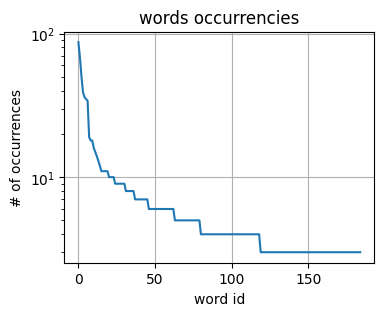

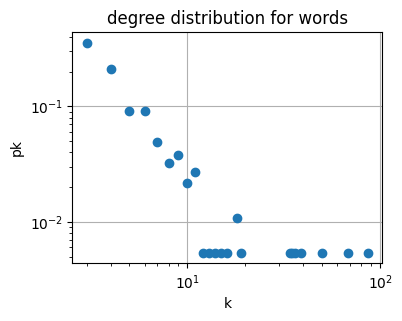

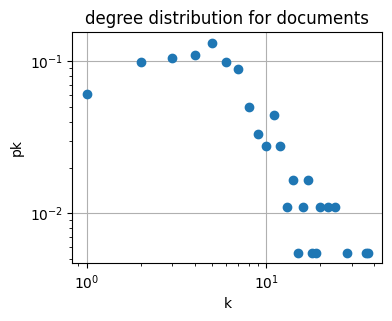

In [52]:
# initialize the class
# use min and max to control which words you are using
td1 = TopicDetection(ct1, n_min=3, n_max=100) # <-- min and max here!
# and build probability matrices first
td1.probability_matrices()
# show words occurrences
td1.plot_word_occurrence()
# show words degree distribution
td1.plot_degree_distributions(quale='words')
# show documents degree distribution
td1.plot_degree_distributions(quale='documents')

# Perform topic detection

Louvain topic detection: execution time 0.2747609615325928 [s]


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


{'topics': 12,
 'com': 0.9331724768565294,
 'time': 0.2747609615325928,
 'NMI': 0.5592747158017829,
 'Q': 0.40579870099110255,
 'Ncut': 0.5026531658695824,
 'Infomap': -0.007825902886975933}

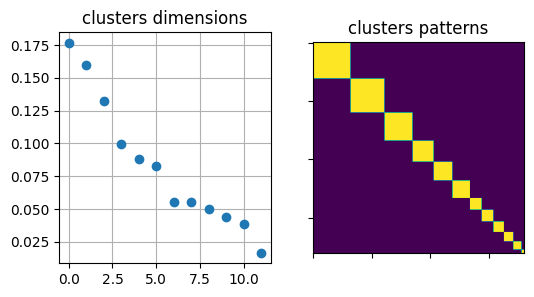

In [53]:
# run louvain clustering - it takes 16 sec for 3K documents
ext = td1.topic_detection_louvain()
# evaluate clustering metrics
td1.clustering_metrics(ext)
# show clusters sizes
td1.display_clusters()
# show statistics
td1.stats

In [54]:
# save topic assignment
df['topic'] = np.nan
topics = np.array(df['topic'])
topics[td1.documents] = td1.topics # not all the documents are assigned to topics!
df['topic'] = topics
df.to_excel("Milton_data_topics.xlsx")

In [55]:
# save class
td1.pickle_export("Milton_results.pickle")

# Topic description

In [56]:
# load data
td2 = TopicDetection()
td2.pickle_import("Milton_results.pickle")

In [57]:
# display keywords from Pwc and BERTopic
active_docs = [ct1.text[i] for i in td2.documents] # not all asiigned to topics
td2.display_keywords(active_docs)

2024-12-31 10:52:52,678 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic,#docs,Probability matrices keywords,BERTopic keywords
0,32,Milton Hurricane HurricaneMilton Florida florida hurricanemilton milton weather Dan Tampa storm USA Lieutenant make man,milton hurricane florida hurricanemilton the de tampa be in en usa weather category dan que
1,29,fyp florida foryoupage viral stephtradez education motivation trend fypシ milton milton foryou give s cook,fyp hurricane foryoupage viral hurricanemilton milton foryou motivation education stephtradez stormsurge trend what storm rescue
2,24,florida milton hurricanemilton tampa 🥂 hurricanemilton pray orlando milton gulfcoast stay safe MILTON come time,florida hurricanemilton milton hurricane for miami preperation tampa gulfcoast stay pray safe indian klaw leanton
3,18,hurricanemilton florida tornado dog dogsoftiktok keep hurricaneseason bring Milton find home Hurricane Orlando pet never,dog tornado hurricanemilton florida to rescue dog dogsoftiktok in pet they the on your be
4,16,fyp florida go flood floridahurricane see Milton Florida hurricanehelene live milton hurricaneseason Hurricane look storm,live hurricane milton floridahurricane fyp hurricanemilton to florida 2024 see how be hurricanehelene flood now
5,15,Florida 🙏 florida sarasota get prayforflorida effect power prayer go leave still behind tampa animal,all we to prayer out very and who in the effect behind prayforflorida florida hurricanemilton
6,10,so 🥲 m hurricanemilton Florida bad expect florida get time make just do hurricaneprep Hurricane,so this for and the my it to I season fall florida in video bad
7,10,evacuate florida last Milton day 💔 home milton Hurricane hurricanemilton safe hurricane hope pray tampa,evacuate last hurricane caroline calloway influencer florida naturaldisaster hurricanemilton cat5 heartbreake pray severeweather prayforflorida to
8,9,️ 😱 MILTON florida Milton Hurricane fyp milton Florida milton usa find hurricane naturaldisaster flood,milton hurricane actually florida usa hurricanemilton the tropicalstorm in but evacuation 2024 weather targetaudience wake
9,8,people start flight hurricanemilton pet crazy know go tampa traffic week hear foryoupage leave different,people be that know start yes pet flight traffic lieutenantdan why be there crazy hurricanemilton


In [61]:

for i in range(td2.pc.shape[1]):
  print(f'topic {i}' )

topic 0
topic 1
topic 2
topic 3
topic 4
topic 5
topic 6
topic 7
topic 8
topic 9
topic 10
topic 11


# Visualize topic dependencies

CPU times: user 49.2 ms, sys: 22.8 ms, total: 72 ms
Wall time: 72.9 ms


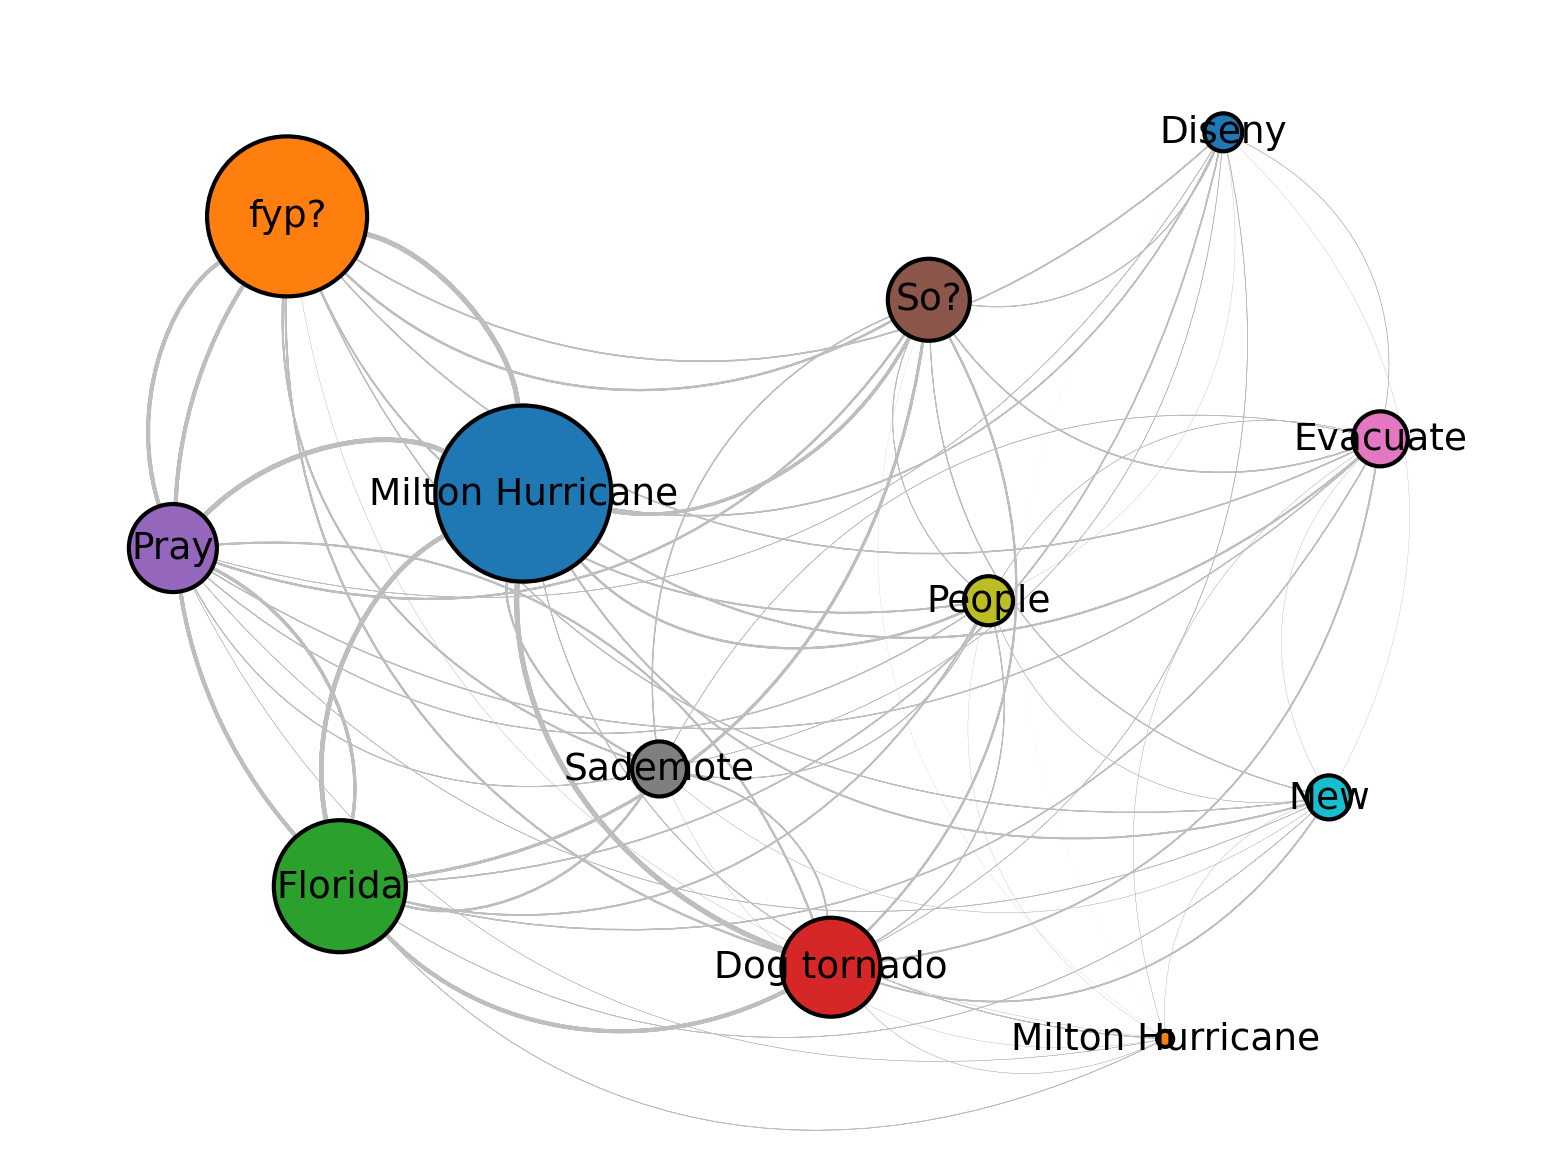

In [62]:
# nodes coordinates by umap: we use communities matrix as adjacency matrix
%time t_pos = umap.UMAP().fit_transform(td2.Pcc.toarray())
t_pos = t_pos-t_pos.mean(0) # we subtract the average values here

# topic centrality by pc
t_cen = np.array(td2.pc)[0]

# topics names
t_names = ["Milton Hurricane", "fyp?", "Florida", "Dog tornado", "Pray", "So?", "Evacuate", "Sademote", "People", "New", "Diseny"]

# topic colors ... hard assignment
t_colors = sns.color_palette("tab10")

# build graph using Pcc
A = td2.Pcc.toarray()
np.fill_diagonal(A, 0)
G = ig.Graph.Adjacency((A>0).tolist())
At = np.tril(A, k=0)
G.es['weight'] = np.array(At[A.nonzero()])

# plot graph
fig, ax = plt.subplots(dpi=300)
ig.plot(G,
        target = ax,
        layout = t_pos,
        vertex_size = 1000*t_cen,
        vertex_color = t_colors,
        vertex_label = t_names,
        vertex_label_size = 9,
        vertex_label_dist = 0,
        edge_width = 100*np.array(G.es["weight"]),
        edge_color = 'gray',
        edge_arrow_size = 0.001
        )